In [1]:
 ## import the necessary packages
import numpy as np 
import helper
import time
from pathlib import Path
import pandas as pd
from scipy.stats import loguniform
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('seaborn')
import seaborn as sns
#plt.style.use('fivethirtyeight')


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#importing all the required ML packages
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier     
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV, KFold 
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_score, classification_report, make_scorer, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score


# fix random seed for reproducibility
seed=42
import random
random.seed(seed)

##**Part 1: Exploratory Data Analysis(EDA):**

In [2]:
train_data = data=pd.read_csv('/content/train.csv')
test_data = data=pd.read_csv('/content/test.csv')

In [3]:
train_data.head()

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male


In [4]:
train_data.info(), test_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Number words female                   1039 non-null   int64  
 1   Total words                           1039 non-null   int64  
 2   Number of words lead                  1039 non-null   float64
 3   Difference in words lead and co-lead  1039 non-null   int64  
 4   Number of male actors                 1039 non-null   int64  
 5   Year                                  1039 non-null   int64  
 6   Number of female actors               1039 non-null   int64  
 7   Number words male                     1039 non-null   int64  
 8   Gross                                 1039 non-null   float64
 9   Mean Age Male                         1039 non-null   float64
 10  Mean Age Female                       1039 non-null   float64
 11  Age Lead         

(None, None)

In [5]:
#checking for missing data
print("Are There Missing Data? :",train_data.isnull().any().any())
train_data.isnull().sum(), test_data.isnull().sum()

Are There Missing Data? : False


(Number words female                     0
 Total words                             0
 Number of words lead                    0
 Difference in words lead and co-lead    0
 Number of male actors                   0
 Year                                    0
 Number of female actors                 0
 Number words male                       0
 Gross                                   0
 Mean Age Male                           0
 Mean Age Female                         0
 Age Lead                                0
 Age Co-Lead                             0
 Lead                                    0
 dtype: int64, Number words female                     0
 Total words                             0
 Number of words lead                    0
 Difference in words lead and co-lead    0
 Number of male actors                   0
 Year                                    0
 Number of female actors                 0
 Number words male                       0
 Gross                                  

In [6]:
train_data.describe(), test_data.describe()

(       Number words female   Total words  ...     Age Lead  Age Co-Lead
 count          1039.000000   1039.000000  ...  1039.000000  1039.000000
 mean           2334.256015  11004.368624  ...    38.716073    35.486044
 std            2157.216744   6817.397413  ...    12.285902    12.046696
 min               0.000000   1351.000000  ...    11.000000     7.000000
 25%             904.000000   6353.500000  ...    30.000000    28.000000
 50%            1711.000000   9147.000000  ...    38.000000    34.000000
 75%            3030.500000  13966.500000  ...    46.000000    41.000000
 max           17658.000000  67548.000000  ...    81.000000    85.000000
 
 [8 rows x 13 columns],
        Number words female   Total words  ...    Age Lead  Age Co-Lead
 count           387.000000    387.000000  ...  387.000000   387.000000
 mean           1504.806202   7277.408269  ...   37.612403    35.392765
 std            1214.142046   3501.962134  ...   12.353794    11.988153
 min               0.000000  

**What is the gender of the lead actor?**

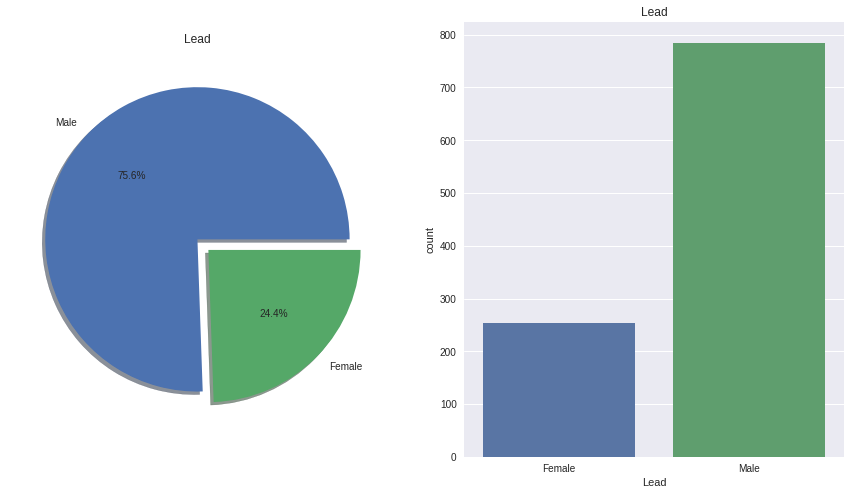

In [7]:
f,ax=plt.subplots(1,2,figsize=(15,8))
train_data['Lead'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Lead')
ax[0].set_ylabel('')
sns.countplot('Lead',data=train_data,ax=ax[1])
ax[1].set_title('Lead')
plt.show()

In [8]:
train_data['Lead'].value_counts()

Male      785
Female    254
Name: Lead, dtype: int64

It is evident that not many lead actors are females. Out of 1037 films in the training set, only 254 are females i.e Only 24.4% of the total training set are females. 

We will try to check the lead actor's gender by using the different features of the dataset. Some of the features being the number of words, number of actors, age, Gross, year, etc...

First let us understand the different types of features.

###**Analysing The Features**

**Year: Has gender balance in speaking roles changed over time (i.e. years)?**

In [9]:
train_data.groupby(['Year','Lead'])['Lead'].count()

Year  Lead  
1939  Female     1
      Male       1
1949  Male       1
1954  Male       2
1958  Female     1
                ..
2013  Male      26
2014  Female     8
      Male      16
2015  Female    10
      Male       9
Name: Lead, Length: 91, dtype: int64

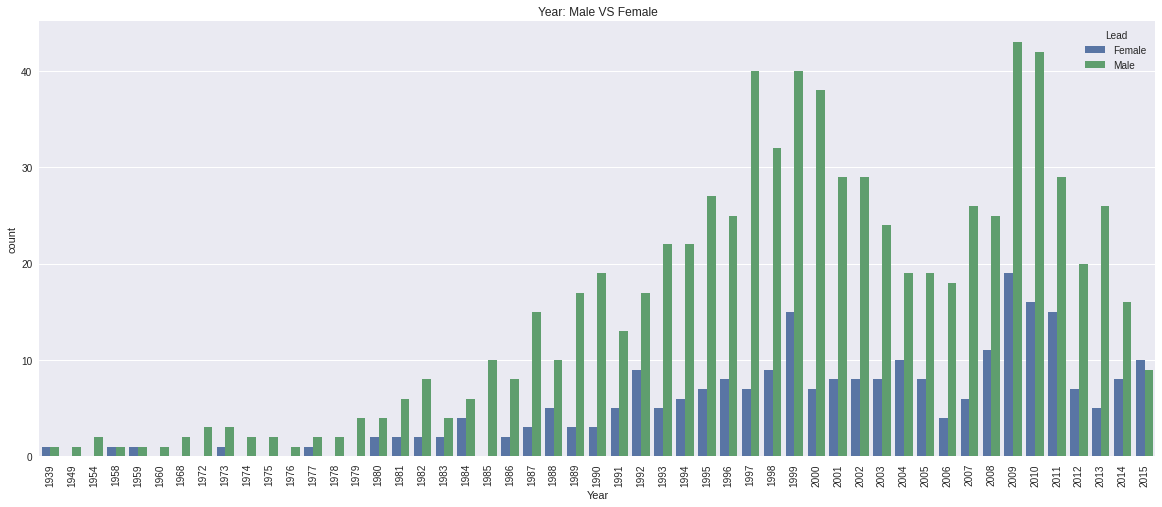

In [10]:
f=plt.subplots(figsize=(20,8))
sns.countplot('Year',hue='Lead',data=train_data)
plt.title('Year: Male VS Female')
plt.xticks(rotation=90)
plt.show()

**Gross: Do films in which men do more speaking make a lot more money than films in which women speak more?**

In [11]:
train_data.groupby(['Gross', 'Lead'])['Lead'].count()

Gross   Lead  
0.0     Female     1
        Male       9
1.0     Female     8
        Male      19
2.0     Female     7
                  ..
882.0   Male       1
937.0   Male       1
1103.0  Male       1
1249.0  Female     1
1798.0  Male       1
Name: Lead, Length: 425, dtype: int64

Text(0.5, 1.0, 'Gross: Male VS Female')

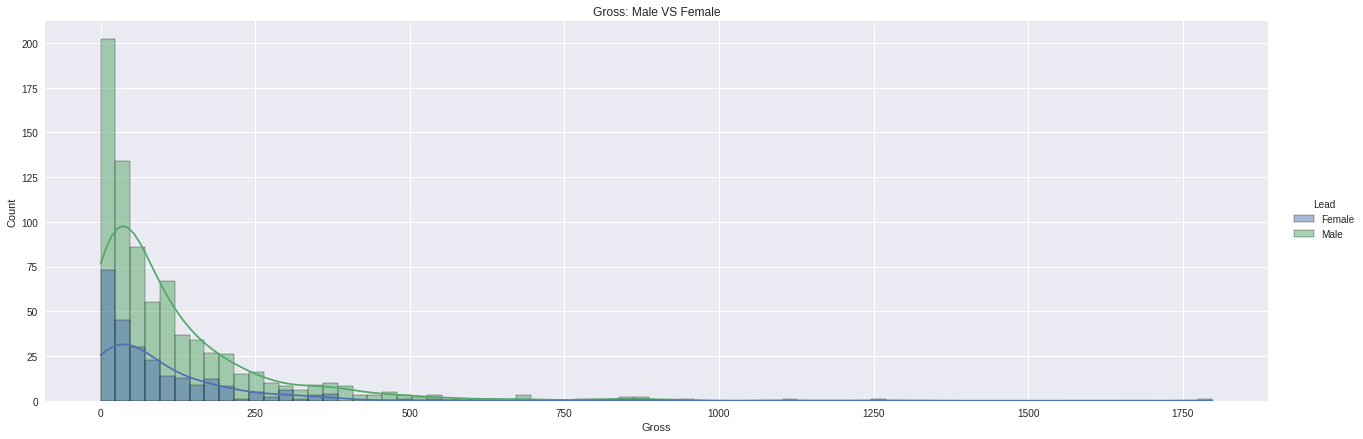

In [12]:
sns.displot(train_data, x="Gross", hue="Lead", kde=True, height=6, aspect=3)
plt.title("Gross: Male VS Female")

**Number of Actors**\
We will look at the distribution of the values within the **Number of female actors**,**Number of male actors** features.

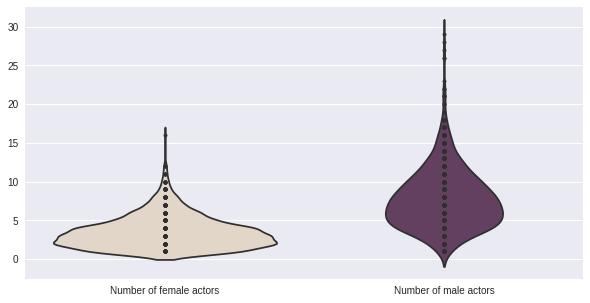

In [13]:
fig= plt.subplots(figsize=(10,5))
pal=sns.cubehelix_palette(2,rot=.5,dark=.3)
sns.violinplot( data=train_data[['Number of female actors','Number of male actors']],  palette=pal, inner="points")
plt.show()

In [14]:
train_data.groupby(['Number of female actors','Lead'])['Lead'].count(), train_data.groupby(['Number of male actors','Lead'])['Lead'].count()

(Number of female actors  Lead  
 1                        Female     21
                          Male      138
 2                        Female     25
                          Male      202
 3                        Female     45
                          Male      163
 4                        Female     56
                          Male      128
 5                        Female     30
                          Male       68
 6                        Female     27
                          Male       44
 7                        Female     21
                          Male       18
 8                        Female     15
                          Male       11
 9                        Female      7
                          Male        5
 10                       Female      3
                          Male        4
 11                       Female      1
                          Male        3
 12                       Female      2
                          Male        1
 16    

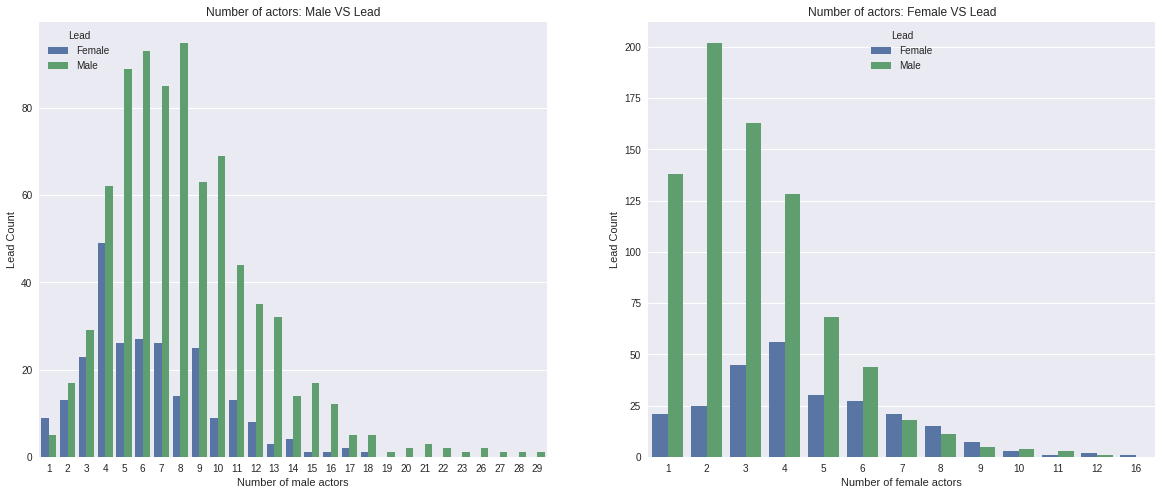

In [15]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2)

sns.countplot('Number of male actors',hue='Lead',data=train_data, ax=axs[0])
axs[0].set_title('Number of actors: Male VS Lead')
axs[0].set_ylabel('Lead Count')


sns.countplot('Number of female actors',hue='Lead',data=train_data, ax=axs[1])
axs[1].set_title('Number of actors: Female VS Lead')
axs[1].set_ylabel('Lead Count')


plt.show()

**Number of Words: Do men or women dominate speaking roles in Hollywood movies?**

Text(0.5, 1.0, 'Total words: Male VS Female')

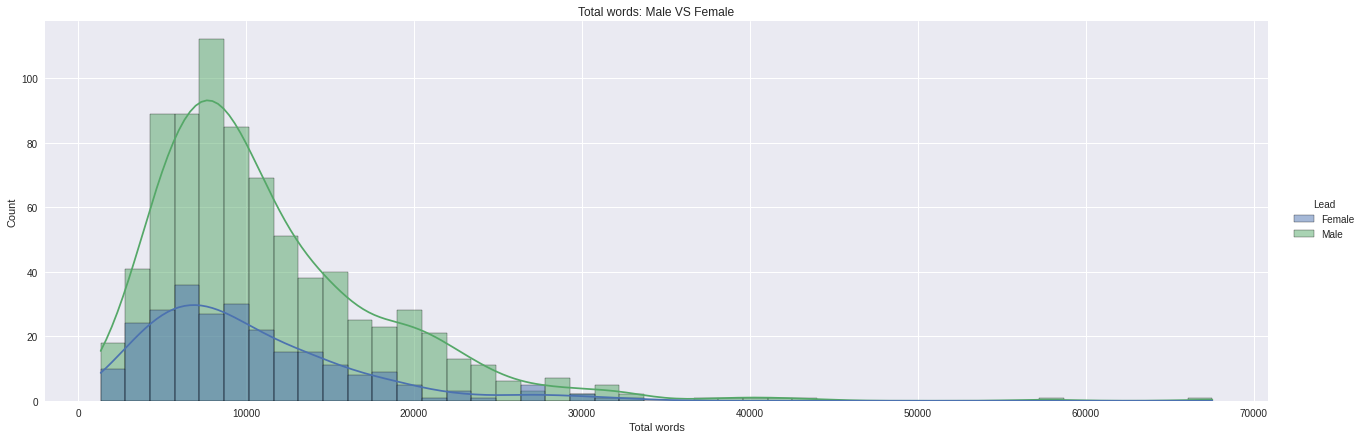

In [16]:
sns.displot(train_data, x="Total words", hue="Lead", kde=True, height=6, aspect=3)
plt.title("Total words: Male VS Female")

Text(0.5, 1.0, 'Word Count: Male VS Lead Actor')

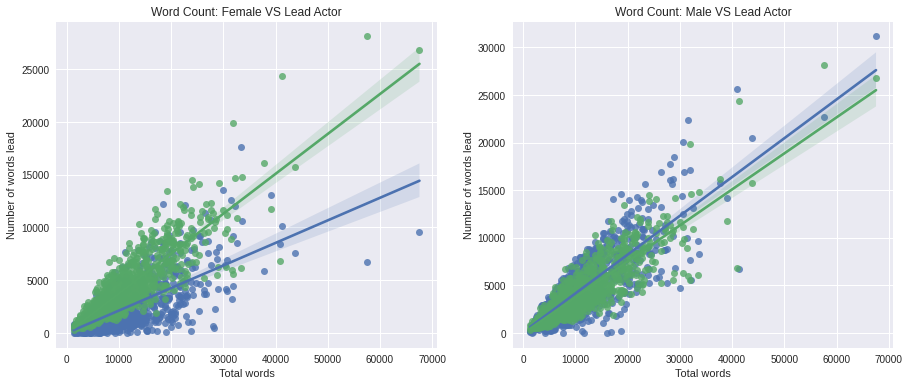

In [17]:
fig, axs = plt.subplots(figsize=(15,6), ncols=2)

sns.regplot(x='Total words', y='Number words female', data=train_data, ax=axs[0])  
sns.regplot(x='Total words', y='Number of words lead', data=train_data, ax=axs[0])
axs[0].set_title('Word Count: Female VS Lead Actor')

sns.regplot(x='Total words', y='Number words male', data=train_data, ax=axs[1])
sns.regplot(x='Total words', y='Number of words lead', data=train_data, ax=axs[1])
axs[1].set_title('Word Count: Male VS Lead Actor')

**Age**

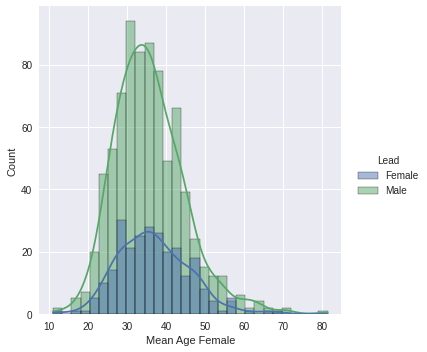

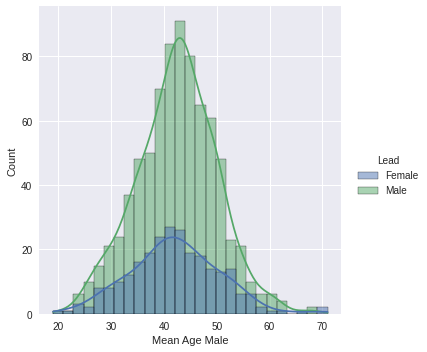

In [18]:
sns.displot(train_data, x="Mean Age Female", hue="Lead", kde=True)
sns.displot(train_data, x="Mean Age Male", hue="Lead", kde=True)

Text(0.5, 1.0, 'Age Co-Lead: Male VS Female')

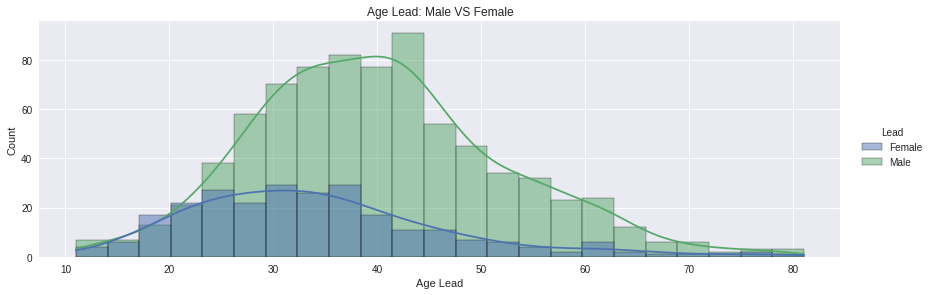

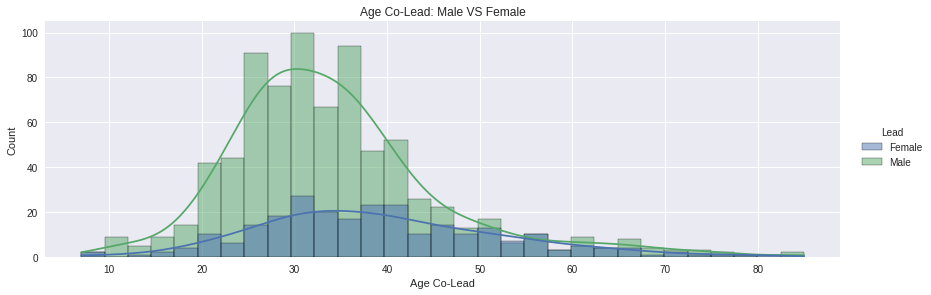

In [19]:
sns.displot(train_data, x="Age Lead", hue="Lead", kde=True, height=4, aspect=3)
plt.title("Age Lead: Male VS Female")
sns.displot(train_data, x="Age Co-Lead", hue="Lead", kde=True, height=4, aspect=3)
plt.title("Age Co-Lead: Male VS Female")

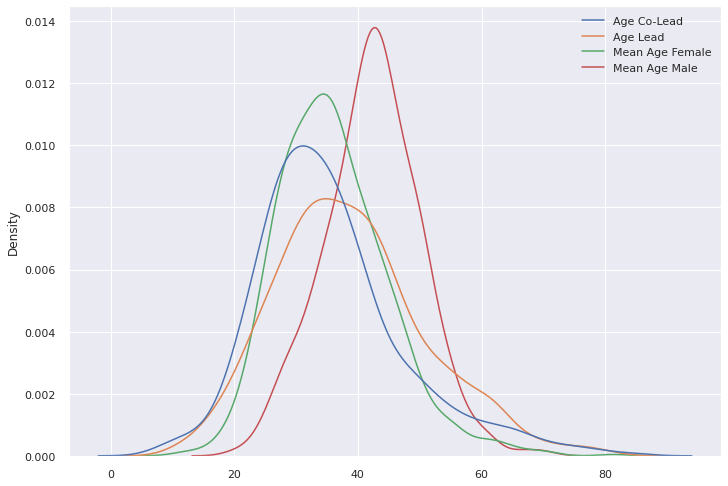

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.kdeplot(data=train_data[['Age Co-Lead', 'Age Lead', 'Mean Age Female', 'Mean Age Male']])

Text(0.5, 1.0, 'Number of Actors: Male VS Lead Actor')

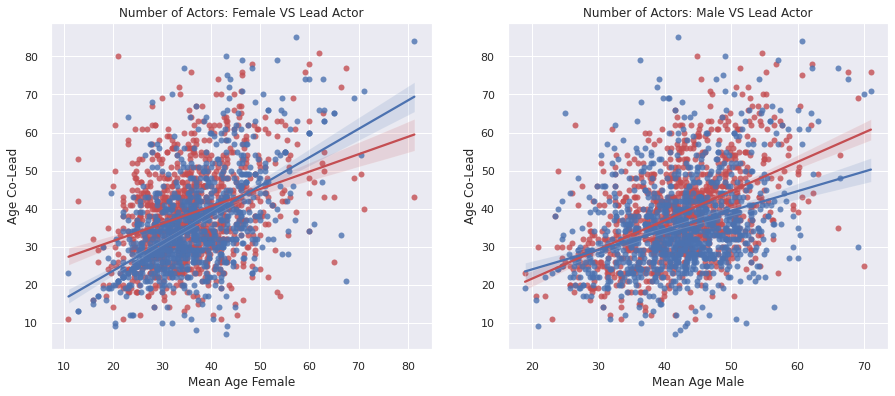

In [21]:
fig, axs = plt.subplots(figsize=(15,6), ncols=2)

sns.regplot(x='Mean Age Female', y='Age Lead', data=train_data, color = 'r', ax=axs[0]) 
sns.regplot(x='Mean Age Female', y='Age Co-Lead', data=train_data, color = 'b', ax=axs[0])
axs[0].set_title('Number of Actors: Female VS Lead Actor')

sns.regplot(x='Mean Age Male', y='Age Lead', data=train_data, color = 'r', ax=axs[1]) 
sns.regplot(x='Mean Age Male', y='Age Co-Lead', data=train_data, color = 'b', ax=axs[1])
axs[1].set_title('Number of Actors: Male VS Lead Actor')

Text(0.5, 1.0, 'Male Age: Lead VS Lead Actor')

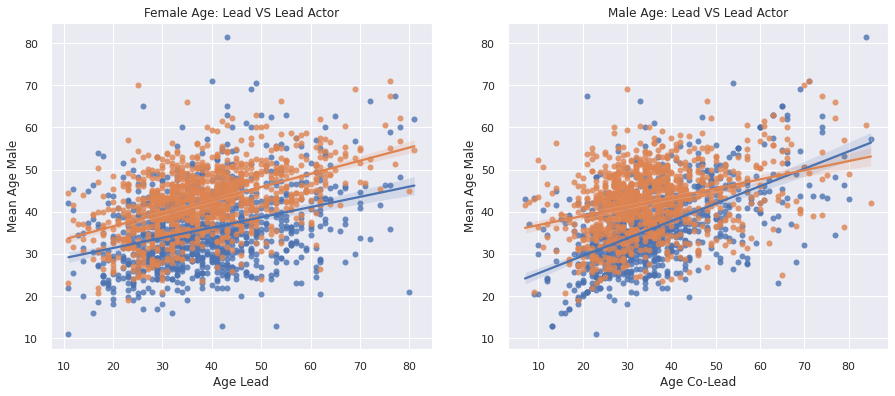

In [22]:
fig, axs = plt.subplots(figsize=(15,6), ncols=2)

sns.regplot(x='Age Lead', y='Mean Age Female',  data=train_data, ax=axs[0]) 
sns.regplot(x='Age Lead', y='Mean Age Male', data=train_data, ax=axs[0]) 
axs[0].set_title('Female Age: Lead VS Lead Actor') 


sns.regplot(x='Age Co-Lead', y='Mean Age Female',  data=train_data, ax=axs[1]) 
sns.regplot(x='Age Co-Lead', y='Mean Age Male', data=train_data, ax=axs[1])  
axs[1].set_title('Male Age: Lead VS Lead Actor')  

**Observations in a Nutshell for all features: Correlation Between The Features**

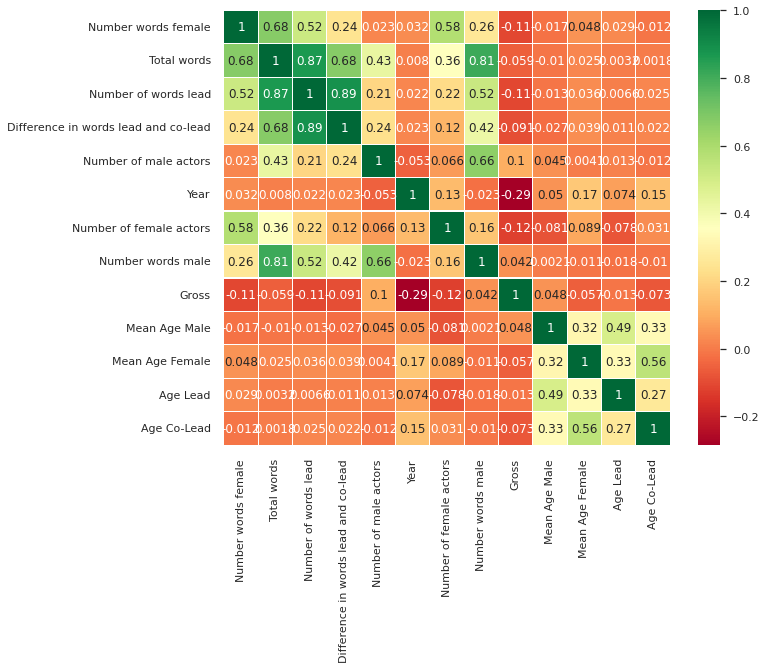

In [23]:
sns.heatmap(train_data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

The first thing to note is that only the numeric features are compared as it is obvious that we cannot correlate between alphabets or strings. 

**POSITIVE CORRELATION:** If an increase in feature A leads to increase in feature B, then they are positively correlated. A value 1 means perfect positive correlation.

**NEGATIVE CORRELATION:** If an increase in feature A leads to decrease in feature B, then they are negatively correlated. A value -1 means perfect negative correlation.

Now lets say that two features are highly or perfectly correlated, so the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. This is known as MultiColinearity as both of them contains almost the same information. This also mean that there is redundant information in the dataset. While making or training models, we should try to eliminate redundant features as it reduces training time and helps us avoid overfitting.

Now from the above heatmap,we can see that some features are correlated. The highest correlations is between:  
1) **Difference in words Lead and Co-Lead** and **Number of words Lead** i.e 0.89. \
2) **Total Words** and **Number of words Lead** i.e 0.87. \
3) **Total Words** and **Number of words Male** i.e 0.81. \
4) **Total Words** and **Difference in words Lead and Co-Lead** i.e 0.68. \
5) **Number of male actors** and **Number of words Male** i.e 0.66. \

###**Models Spotchecking**

**Checking the performance of the ML models on the raw data. We will also use the default parameters for binary classification**. We will test the following classifiers:

*   Linear Discriminant Analysis
*   Quadratic Discriminant Analysis
*   Logistic Regression
*   K-Nearest Neighbours
*   Decision Tree
*   Random Forest
*   Bagging
*   AdaBoost
*   LightGBM
*   Gradient Boosting Classifier
*   XGBoost



Randomness is used in the construction of the model. This means that each time the algorithm is fit to the data, it will produce slightly different results.
When using machine learning algorithms that have a stochastic learning algorithm, it is a good practice to evaluate them by averaging their performance across multiple runs or repeats of cross-validation. 

We will evaluate the model by using repeated Stratified k fold cross-validation, with three repeats and 10 folds. We use the stratified version because our dataset is highly imbalanced. The stratified Kfold will ensure that the same proportions of male and female in the original dataset is kept in when splitting the data. Furthermore, having the 'accuracy' as a metric is biased. F1, Precision, and recall are a better evaluation metrics.

In [24]:
class ModelComparison():
  """
  A class to comapre, evaluate, train, and test Machine Learning Models .

  ...
      
  Parameters
  -----------
  train_data : pandas dataframe
     The training portion of the Hollywood Movie Actors dataset
  test_size : float
     Proportion of the test dataset (test_size*train_data.shape)
  n_cols : int
     Number of features
  n_splits : int
     Number of folds
  k: int, default None
    Number of Neighbours

  Attributes
  ----------
  labels: list
    targets ['Male', 'Female']
  metrics_list : list
    list of all the evaluation metrics 
  kfold : RepeatedStratifiedKFold
    Repeated Stratified K-Fold cross validator

  """


  def __init__(self, train_data, test_size, n_cols, n_splits, k=None):
    """
    Constructs all the necessary attributes for the ModelComparison object.
    """    

    self.k = k
    self.seed = seed
    self.n_cols = n_cols
    self.labels = ['Male', 'Female']
    self.n_splits = n_splits
    self.test_size = test_size
    self.train_data = train_data
    self.metrics_list = ["accuracy", "precision_macro", "recall_macro", 'f1_macro']
    self.acc, self.f1, self.recall, self.precision, self.names = [], [], [], [], []
    self.train_conf_mat, self.test_conf_mat = [], []
    self.kfold = RepeatedStratifiedKFold(n_splits=self.n_splits, n_repeats=3, 
                                         random_state = 1)




  def train_valid_test_data(self):
    """
    Splits the Train dataframe into a train and a test datasets
    """

    #X = train_data[train_data.columns[:13]]
    #Y = train_data['Lead']
    train, test = train_test_split(self.train_data, 
                                   test_size=self.test_size, 
                                   random_state=seed, 
                                   stratify=self.train_data['Lead'])
    
    train_X = train[train.columns[:self.n_cols]]
    train_Y = train.Lead
    test_X  = test[test.columns[:self.n_cols]]
    test_Y  = test.Lead

    return train_X, train_Y, test_X, test_Y



  def evaluate_models(self, models):
    """
    evaluate each model in turn (spot checking algorithms (of baselines))
    """

    
    train_X, train_Y, _, _ = self.train_valid_test_data()

    for name, model in models:
      self.names.append(name)
      print(name)
      print()
      for metric in self.metrics_list:
        cv_results = cross_val_score(model, train_X, train_Y,
                                     cv=self.kfold, scoring=metric,
                                     n_jobs=-1, error_score='raise')
        
        
        if metric =='accuracy':
          self.acc.append(cv_results)
        if metric =='precision_macro':
          self.precision.append (cv_results)
        if metric =='recall_macro':
          self.recall.append (cv_results)
        if metric =='f1_macro':
          self.f1.append (cv_results)
        print('%s: %f (%f)' % (metric, cv_results.mean(), cv_results.std()))
      print('------------------------------------------------------------')



  def hyperparameter_tuning(self, models_and_parameters):
    """
    Given a grid of parameters, it performs a randomized search for each model
    and return the best hyperparameters. It uses only the train portion 
    for training and validation.
    """
    

    train_X, train_Y, _, _ = self.train_valid_test_data()
    
    for name, (model, params) in models_and_parameters.items():
      print(name)

      # define and execute the randomized search procedure
      random_search = RandomizedSearchCV(estimator=model, 
                                         param_distributions=params, 
                                         scoring='f1_macro',
                                         cv=self.kfold,
                                         n_jobs=-1, 
                                         random_state=seed).fit(train_X, train_Y)

      # summarize the best score and configuration
      print("Best: %f using %s" % (random_search.best_score_, 
                                   random_search.best_params_))
    


  def model_train_validation (self, models, oversample):
    """
    Trains the tuned models using the training portion 
    and tests them using the test portion.
    """


    if oversample == True:
      _, _, test_X, test_Y = self.train_valid_test_data()
      train_X, train_Y = self.Over_sample()
    
    else:
      train_X, train_Y, test_X, test_Y = self.train_valid_test_data()


    for name, model in models:
      print(name)

      # Train
      model.fit(train_X, train_Y)
      train_pred = model.predict(train_X)
      train_precision = precision_score(train_Y,
                                        train_pred, 
                                        average='macro', 
                                        labels=np.unique(train_pred))
      
      train_recall = recall_score(train_Y, train_pred, average='macro')
      train_F1 = 2* train_precision*train_recall/(train_precision+train_recall)
      self.conf_arr = confusion_matrix (train_Y, train_pred)
      self.train_conf_mat.append(self.conf_arr)


      print()
      print('Train results:') 
      print()
      print(">precision_macro:"   , train_precision)
      print(">recall_macro:"      , train_recall)
      print(">f1_macro:"          , train_F1)
      print("Confusion Matrix:")
      

      # Test
      test_pred = model.predict(test_X)
      test_precision = precision_score(test_Y, test_pred, 
                                        average='macro', 
                                        labels=np.unique(test_pred))
      test_recall = recall_score(test_Y, test_pred, average='macro')
      test_F1 = 2* test_precision*test_recall/(test_precision+test_recall)
      self.conf_arr = confusion_matrix (test_Y, test_pred)
      self.test_conf_mat.append(self.conf_arr)

      print()
      print('Test results:') 
      print()
      print(">precision_macro:"   , test_precision)
      print(">recall_macro:"      , test_recall)
      print(">f1_macro:"          , test_F1)
      print("Confusion Matrix:")
      print(self.conf_arr)
      print('-----------------------------------------------------------------')

  

  def pca_analysis (self):

    """
    Principle component analysis to find the features in the dataset 
    that are responsible for the majority of the variance in the dataset.
    """
    
    train_X, _, test_X, _ = self.train_valid_test_data()
    
    # Applying PCA to the train and valid datasets
    pca = PCA(n_components=3).fit(train_X)  
    pc_train = pca.transform(train_X)
    pc_test  = pca.transform(test_X)

    # number of components
    n_pcs= pca.components_.shape[0]

    # get the index of the most important feature on EACH component
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    initial_feature_names = list(train_X.columns)
 
    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    df = pd.DataFrame(dic.items())
    exp_var_cumsum=pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),4)*100)
    df.columns = ['PC', 'Features']
    df['variance_ratio'] = exp_var_cumsum
        
    return df



  def Over_sample (self):
    """
    Over-samples the minority class. It creates a new sample based
    on the K neighbors
    """

    train_X, train_Y, _, _ = self.train_valid_test_data()
    sm = SMOTE(sampling_strategy='minority', k_neighbors=self.k, 
               random_state=seed)
    X, Y = sm.fit_resample(train_X, train_Y)
    return X, Y



  def Inference(self):
    """
    Tests the selected final model on the unseen data
    """
    pass





  def box_plots (self):

    """
    Generates boxplots based on the comparison results.
    """

    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    axs[0].boxplot(self.f1, labels= self.names)
    axs[0].set_title("Algorithm comparison -- F1 score")
    plt.grid()

    axs[1].boxplot(self.acc, labels=self.names)
    axs[1].set_title("Algorithm comparison -- Accuracy")
    plt.grid()

    plt.show()

In [25]:
# Model selection 
# Create a list of standard classifiers
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))                 
models.append(('QDA', QuadraticDiscriminantAnalysis()))  
models.append(('LR', LogisticRegression(random_state=seed, n_jobs=-1)))                 
models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))                
models.append(('CART', DecisionTreeClassifier(random_state=seed)))             
models.append(('Bag', BaggingClassifier(random_state=seed, n_jobs=-1)))                          
models.append(('Ada', AdaBoostClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_jobs=-1,random_state=seed)))
models.append(('GBC', GradientBoostingClassifier(random_state=seed)))
models.append(('Lgbm', LGBMClassifier(random_state=seed)))
models.append(('XGB', XGBClassifier(n_jobs=-1, random_state=seed)))

LDA

accuracy: 0.877184 (0.035066)
precision_macro: 0.869048 (0.060224)
recall_macro: 0.787452 (0.055298)
f1_macro: 0.814029 (0.054528)
------------------------------------------------------------
QDA

accuracy: 0.835725 (0.071492)
precision_macro: 0.798542 (0.072849)
recall_macro: 0.812956 (0.056665)
f1_macro: 0.793765 (0.071560)
------------------------------------------------------------
LR

accuracy: 0.815557 (0.027126)
precision_macro: 0.789795 (0.070698)
recall_macro: 0.668868 (0.044701)
f1_macro: 0.692660 (0.049880)
------------------------------------------------------------
KNN

accuracy: 0.786086 (0.027723)
precision_macro: 0.728535 (0.084410)
recall_macro: 0.613718 (0.044962)
f1_macro: 0.625927 (0.057873)
------------------------------------------------------------
CART

accuracy: 0.784366 (0.042338)
precision_macro: 0.708816 (0.057113)
recall_macro: 0.702906 (0.067171)
f1_macro: 0.702241 (0.061179)
------------------------------------------------------------
Bag

accuracy: 

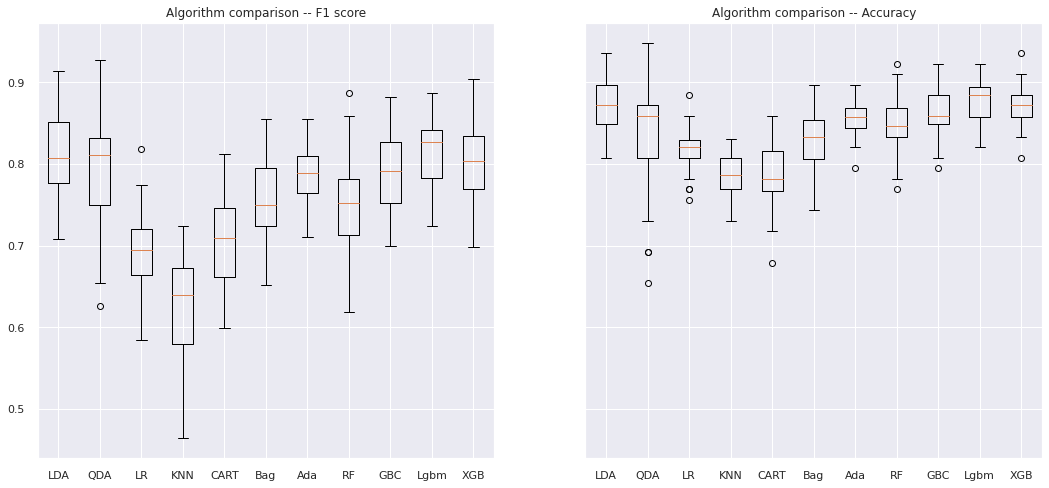

In [26]:
spot_checking = ModelComparison(train_data=train_data, test_size=0.25, n_cols=13, n_splits=10)
# get the data
train_X, train_Y, test_X, test_Y = spot_checking.train_valid_test_data()
#evaluate the models using the raw data
spot_checking.evaluate_models(models)
spot_checking.box_plots ()

We can see that the performance is mediocre at best. The F1 score ranges from 62% to 81%. We can do better than this. 

**Finding out the most important features using PCA**

In [27]:
spot_checking.pca_analysis()

,PC,Features,variance_ratio
0,PC0,Total words,84.95
1,PC1,Number words male,93.67
2,PC2,Number words female,99.46


In [28]:
#Let's say you would like to explain 99% variance  
pca=PCA(0.99).fit(train_X) 
pc_train = pca.transform(train_X) 
print('Number of components to explain 99% Variance is',pca.n_components_)
print()
# Dump components relations with features:
pca_components=pd.DataFrame(pca.components_,columns=train_X.columns,index = ['PC-1', 'PC-2', 'PC-3'])
pca_components

Number of components to explain 99% Variance is 3



,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead
PC-1,0.156907,0.832746,0.332788,0.231257,0.000208,0.000002,0.000086,0.343051,-0.001383,3.587286e-07,0.000020,0.000002,-0.000007
PC-2,0.122996,-0.076885,0.490465,0.511639,-0.000629,0.000156,0.000003,-0.690346,-0.007150,-3.406513e-05,0.000128,0.000045,0.000133
PC-3,0.737047,0.213718,-0.152137,-0.500135,-0.000479,0.000174,0.000430,-0.371192,-0.004603,1.051711e-06,0.000050,0.000061,-0.000111


Based on these results, we can see that the most important features that hold most of the information and are responsible for 98% of the variance in the dataset are:


*   Total words
*   Number of words female
*   Number of words male

We can also see that "year", "number of male actors", "number of female actors", "Age Co-lead", "Age lead", "Mean Age Male", and "Mean Age female" contribute the least to the final results. 

To confirm these results, we will use the feature importance method in lightGBM classifier. LightGBM was chosen here because it is the fastest and it yielded the best results out the plethora of models that we tested.



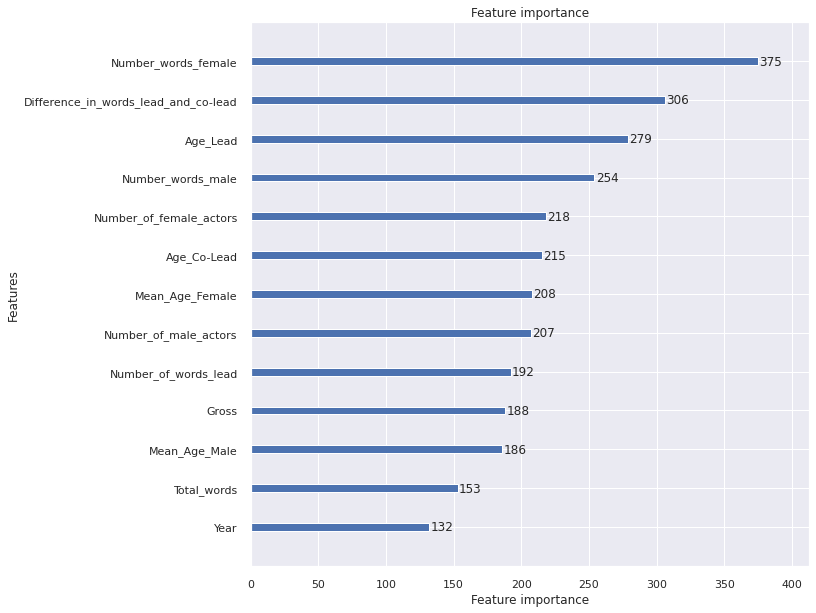

In [29]:
#Train LightGBM classifier using the raw training data and the default parameters
classifier = LGBMClassifier(random_state=seed).fit(train_X, train_Y)
#Plot feature importance
fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(classifier, ax=ax, height=0.2, xlim=None, ylim=None, title='Feature importance', 
                         ylabel='Features')

We can see that there is some agreement between the results of lightGBM and PCA. **Number of words male** and **number of words female** seem to be the most important features while **Year** is not that important. However, unlike PCA, LigthGBM didn't find **Total words** to be an important feature.

One final check would be to run lightgbm using only the three features that PCA found the most important. When using all the data, this classifier gave the following results:

*   Accuracy: 0.874192 (0.027402)
*   Precision_macro: 0.853006 (0.044556)
*   Recall_macro: 0.792022 (0.050351)
*   F1_macro: 0.813170 (0.045810)

In [30]:
def train_lgb (train_X, train_Y):
  classifier = LGBMClassifier(random_state=seed)
  kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  for metric in ["accuracy", "precision_macro", "recall_macro", 'f1_macro']:
    cv_results = cross_val_score(classifier, train_X, train_Y, cv=kfold, 
                                 scoring=metric, n_jobs=-1, error_score='raise')
    print('%s: %f (%f)' % (metric, cv_results.mean(), cv_results.std()))
  print('-------------------------------------------------------------')

#Train LightGBM classifier using the "Total words", "Number of words female", "Number of words male", and the default parameters
print("train data: 'Total words', 'Number words female', 'Number words male' " )
train_lgb (train_X[['Total words', 'Number words female', 'Number words male']], train_Y)

#Train LightGBM classifier using the "PC1", "PC2", "PC3", and the default parameters
print("train data: 'PC1', 'PC2', 'PC3' " )
train_lgb (pc_train, train_Y)

train data: 'Total words', 'Number words female', 'Number words male' 
accuracy: 0.707304 (0.031926)
precision_macro: 0.557746 (0.057721)
recall_macro: 0.540219 (0.039558)
f1_macro: 0.538664 (0.046537)
-------------------------------------------------------------
train data: 'PC1', 'PC2', 'PC3' 
accuracy: 0.701743 (0.033502)
precision_macro: 0.545114 (0.055573)
recall_macro: 0.528221 (0.036114)
f1_macro: 0.523761 (0.041459)
-------------------------------------------------------------


We can see that the performance is very mediocre, when using only the three main features selected by PCA from the training data or the resulting principle components.

In this section we will try to investigate the importance of the following features:

*   Words spoken by males and females
*   Year of release
*   Money made by film



In [31]:
#Train LightGBM classifier using the  "Number of words female", "Number of words male", "Year", "Gross", and the default parameters
print("train data:  'Number words female', 'Number words male', 'Year', 'Gross' ")
train_lgb (train_X[['Number words female', 'Number words male', 'Year', 'Gross']], train_Y)

#Train LightGBM classifier using the  "Number of words female", "Number of words male", and the default parameters
print("train data:  'Number words female', 'Number words male' ")
train_lgb (train_X[['Number words female', 'Number words male']], train_Y)

#Train LightGBM classifier using the  "Number of words female", and the default parameters
print("train data:  'Number words female' ")
train_lgb (train_X[['Number words female']], train_Y)

#Train LightGBM classifier using the   "Number of words male", and the default parameters
print("train data:   'Number words male' ")
train_lgb (train_X[[ 'Number words male']], train_Y)

#Train LightGBM classifier using the "Year", and the default parameters
print("train data:  'Year' ")
train_lgb (train_X[['Year']], train_Y)

#Train LightGBM classifier using the "Gross", and the default parameters
print("train data:  'Gross' ")
train_lgb (train_X[['Gross']], train_Y)

train data:  'Number words female', 'Number words male', 'Year', 'Gross' 
accuracy: 0.716350 (0.035726)
precision_macro: 0.565771 (0.072546)
recall_macro: 0.540273 (0.043881)
f1_macro: 0.537677 (0.052678)
-------------------------------------------------------------
train data:  'Number words female', 'Number words male' 
accuracy: 0.714191 (0.037092)
precision_macro: 0.569986 (0.073591)
recall_macro: 0.540615 (0.040353)
f1_macro: 0.538047 (0.048454)
-------------------------------------------------------------
train data:  'Number words female' 
accuracy: 0.756549 (0.030440)
precision_macro: 0.661582 (0.125337)
recall_macro: 0.553182 (0.037373)
f1_macro: 0.546077 (0.051601)
-------------------------------------------------------------
train data:   'Number words male' 
accuracy: 0.735542 (0.022064)
precision_macro: 0.524812 (0.125781)
recall_macro: 0.507816 (0.024385)
f1_macro: 0.471774 (0.040639)
-------------------------------------------------------------
train data:  'Year' 
accur

##**Part 2: Feature Engineering:**

At this level, we will try to eliminate  redundant features and get, transform, or add new features by observing or extracting information from other features.



**Converting String Values into Numeric:**

In [27]:
train_data['Lead'].replace(['Male','Female'], [0,1], inplace=True)

In [28]:
train_data.head()

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,1
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,0
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,0
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,0
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,0


**Total Number of Actors** and **Number of words co-lead**

At this point, we can create new features called:\
1) **Total Number of Actors** is the summation of **Number of male actors** and **Number of female actors**. It gives us a combined data so that we can check if Lead gender have anything to do with Total Number of Actors.

2) **Number of words co-lead** is the difference between the **Number of words lead** and the **Difference in words lead and co-lead**. Consequently, we can delete the latter column.

In [29]:
# Total Number of Actors
train_data['Total Number of Actors']  = train_data['Number of female actors'] + train_data['Number of male actors']
train_data['Number of words co-lead'] = train_data['Number of words lead'] - train_data['Difference in words lead and co-lead']

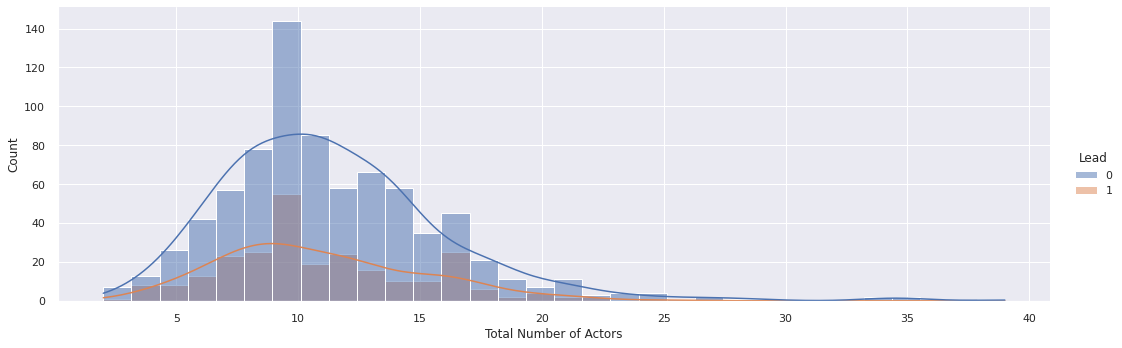

In [30]:
sns.displot(train_data, x="Total Number of Actors", hue="Lead", kde=True, height=5, aspect=3)

**Normalizing the Data: Getting the fraction of the words**

Since our dataset is composed of numerical variables, it is a good practice to have them in similar ranges to avoid uncessary bias. We can see that the number of words columns have higher ranges compared to the number of actors. Therefore, we will devide **Number words female**, **Number words male**, **Number of words lead**, and **Number of words co-lead** by **Total words** to get fractions. Likewise, we will transform the **Number of male actors**, and **Number of female actors** to fractions.



In [31]:
train_data['Number words female']  /= train_data['Total words']
train_data['Number words male']  /= train_data['Total words']
train_data['Number of words lead'] /= train_data['Total words']
train_data['Number of words co-lead'] /= train_data['Total words']

train_data ['Number of female actors'] /= train_data['Total Number of Actors']
train_data ['Number of male actors'] /= train_data['Total Number of Actors']

**Normalizing the Data: standardizing the age and Gross**

In [32]:
train_data['Gross']=(train_data['Gross']-train_data['Gross'].mean())/train_data['Gross'].std()
train_data['Mean Age Female']=(train_data['Mean Age Female']-train_data['Mean Age Female'].mean())/train_data['Mean Age Female'].std()
train_data['Mean Age Male']=(train_data['Mean Age Male']-train_data['Mean Age Male'].mean())/train_data['Mean Age Male'].std()
train_data['Age Lead']=(train_data['Age Lead']-train_data['Age Lead'].mean())/train_data['Age Lead'].std()
train_data['Age Co-Lead']=(train_data['Age Co-Lead']-train_data['Age Co-Lead'].mean())/train_data['Age Co-Lead'].std()

In [33]:
# Dropping unecessary columns
train_data = train_data.drop(['Total words', 'Difference in words lead and co-lead', 'Year', 'Total Number of Actors'], axis=1)
train_data.head()

,Number words female,Number of words lead,Number of male actors,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead,Number of words co-lead
0,0.236472,0.352049,0.285714,0.714286,0.411480,0.203285,1.170028,0.714928,0.592869,2.449963,1,0.298405
1,0.173576,0.230068,0.692308,0.307692,0.596355,-0.488590,-0.413038,-0.736420,1.569598,-0.123357,0,0.091230
2,0.037117,0.225575,0.875000,0.125000,0.737308,1.745177,0.018707,0.119503,0.592869,0.125674,0,0.037117
3,0.108879,0.349061,0.857143,0.142857,0.542060,-0.607197,-0.912299,-1.610950,-0.465255,-1.036470,0,0.082902
4,0.171306,0.498829,0.666667,0.333333,0.329865,-0.468822,0.370499,1.012640,-0.221072,0.291695,0,0.089230


In [34]:
# reorder the table
cols = train_data.columns.to_list()
cols = cols[:10] + [cols[11], cols [10]]
new_train_data = train_data[cols]
new_train_data.head()

,Number words female,Number of words lead,Number of male actors,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Number of words co-lead,Lead
0,0.236472,0.352049,0.285714,0.714286,0.411480,0.203285,1.170028,0.714928,0.592869,2.449963,0.298405,1
1,0.173576,0.230068,0.692308,0.307692,0.596355,-0.488590,-0.413038,-0.736420,1.569598,-0.123357,0.091230,0
2,0.037117,0.225575,0.875000,0.125000,0.737308,1.745177,0.018707,0.119503,0.592869,0.125674,0.037117,0
3,0.108879,0.349061,0.857143,0.142857,0.542060,-0.607197,-0.912299,-1.610950,-0.465255,-1.036470,0.082902,0
4,0.171306,0.498829,0.666667,0.333333,0.329865,-0.468822,0.370499,1.012640,-0.221072,0.291695,0.089230,0


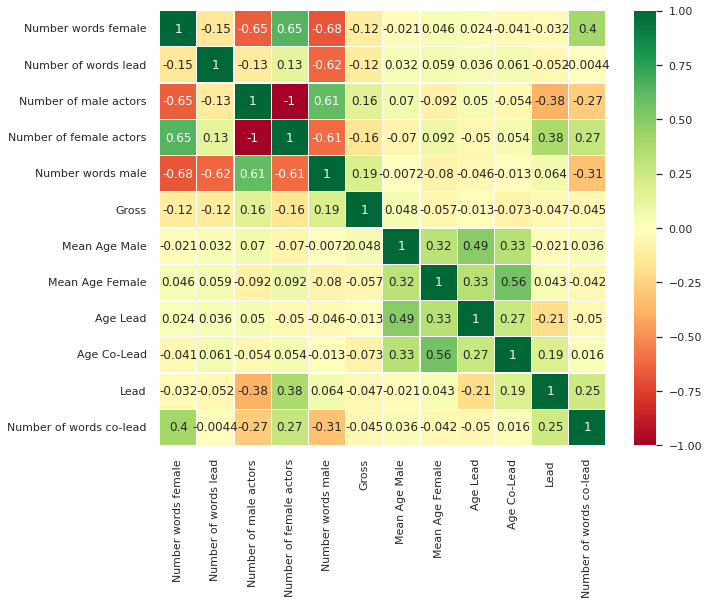

In [35]:
sns.heatmap(train_data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

##**Part 3: Models Evaluation using the new data:**

LDA

accuracy: 0.891889 (0.032377)
precision_macro: 0.878869 (0.050424)
recall_macro: 0.819919 (0.054056)
f1_macro: 0.841301 (0.050019)
------------------------------------------------------------
QDA

accuracy: 0.582693 (0.169238)
precision_macro: 0.624453 (0.083740)
recall_macro: 0.609447 (0.091386)
f1_macro: 0.519116 (0.134234)
------------------------------------------------------------
LR

accuracy: 0.849683 (0.032957)
precision_macro: 0.835835 (0.064055)
recall_macro: 0.732502 (0.054747)
f1_macro: 0.761352 (0.060267)
------------------------------------------------------------
KNN

accuracy: 0.780866 (0.025911)
precision_macro: 0.707178 (0.060838)
recall_macro: 0.620211 (0.043937)
f1_macro: 0.632925 (0.053187)
------------------------------------------------------------
CART

accuracy: 0.875736 (0.038799)
precision_macro: 0.836135 (0.052268)
recall_macro: 0.831244 (0.066804)
f1_macro: 0.829502 (0.057831)
------------------------------------------------------------
Bag

accuracy: 

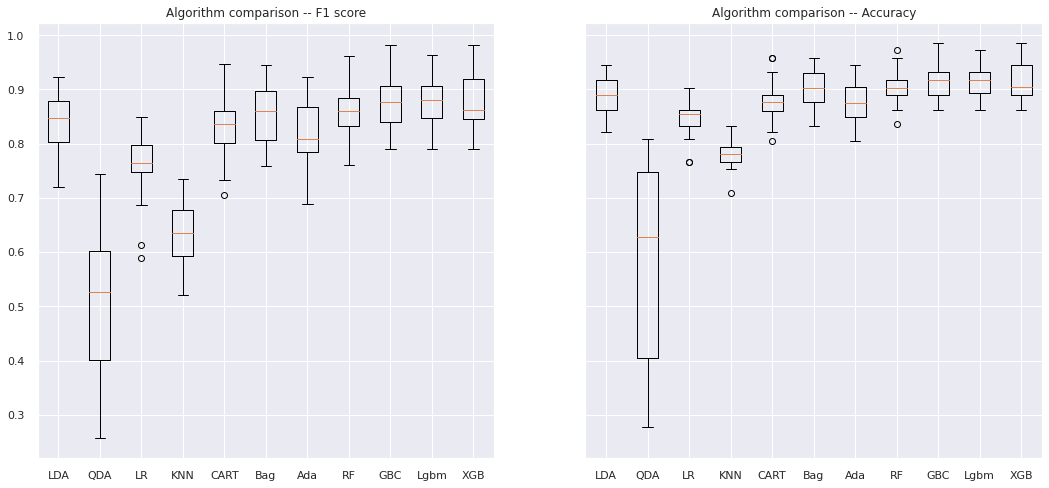

In [36]:
spot_checking2 = ModelComparison(train_data=new_train_data, test_size=0.3, n_cols=11, n_splits=10)
# get the data
train_X, train_Y, test_X, test_Y = spot_checking2.train_valid_test_data()
#evaluate the models using the raw data
spot_checking2.evaluate_models(models)
spot_checking2.box_plots ()

We can see an interesting improvement in all classifiers, except for KNN. 
Now will see if hyperparameter tuning will be of added value or not.

##**Part 4: Hyperparameter Tuning:**


**Create parameter grids to sample from during fitting**

In [43]:
## LDA/QDA hyperparameters
lda_solver = ['svd', 'lsqr', 'eigen']
shrinkage  = np.arange(0, 1, 0.01)
reg_param = [0.1, 0.2, 0.3, 0.4, 0.5]

## Logistic regression hyperparameters
lr_solver = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet']
C= [0.001, 0.01, 0.1, 1, 10, 100, 1000]


## Tree based and ensemble models
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 110, num = 20)]
# Minimum number of samples required to split a node
min_sample_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20, 50, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Learning rate
learning_rates = [1, 0.5, 0.25, 0.1, 0.01, 0.05, 0.005, 0.0001]  
# Number of features to consider at every split
max_features= ['auto', 'sqrt', 'log2']
# Number of trees
n_estimators=[10, 32, 50, 64, 100, 200, 300, 400, 500, 600, 700]



# LightGBM hyperparameters
num_leaves= list(range(20, 150))
boosting_type = ['gbdt', 'goss', 'dart']
reg_alpha  = [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
reg_lambda = [0, 1e-1, 1, 5, 10, 20, 50, 100]

#BAG classifier hyperparameters
features=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0]


# Create a parameter grid to sample from during fitting  

models_and_parameters = {
    
    # 1st param grid, corresponding to Linear Discriminant Analysis (LDA)
    'LDA': (LinearDiscriminantAnalysis(),              
            {'solver': lda_solver,  
             'shrinkage': shrinkage}), 

    # 2nd param grid, corresponding to Quadratic Discriminant Analysis (QDA)
    'QDA': (QuadraticDiscriminantAnalysis(),              
            {'reg_param': reg_param}),

    
    # 3rd param grid, corresponding to KNeighborsClassifier
    'KNeighborsClassifier': (KNeighborsClassifier( n_jobs=-1),              
                             {'n_neighbors': list(range(2,20)),  # nbr of neighbors
                              'weights': ["uniform", "distance"],
                              'metric' : ['minkowski','euclidean','manhattan']}),                      

              
    # 4th param grid, corresponding to CART (DT)
    'CART':(DecisionTreeClassifier(random_state=seed),
            {'criterion':['gini','entropy'],
             'max_depth':max_depth, 
             'max_features':max_features,
             'min_samples_leaf': min_samples_leaf,
             'min_samples_split':min_sample_split}),


    # 5th param grid, corresponding to Logistic Regression 
    'Logistic_reg':(LogisticRegression(n_jobs=-1, random_state=seed),
            {'solver':lr_solver,
             'penalty':penalty, 
             'C':C}),


    # 6th param grid, corresponding to AdaBoost
    'AdaBoost': (AdaBoostClassifier(DecisionTreeClassifier(), random_state=seed),
                 {'learning_rate': learning_rates,
                  'n_estimators': n_estimators, 
                  'algorithm' : ["SAMME","SAMME.R"],
                  'base_estimator__criterion' : ["gini", "entropy"],
                  'base_estimator__splitter' :   ["best", "random"]}),


    # 7th param grid, corresponding to LGBMClassifier          
    'lightgbm': (LGBMClassifier(n_jobs=-1, random_state=seed, objective='binary', metric='logloss'),
                 {'learning_rate': learning_rates,
                  'n_estimators': n_estimators,
                  'reg_alpha' : reg_alpha,
                  'reg_lambda' : reg_lambda,
                  'boosting_type':boosting_type}), 
                         

    # 8th param grid, corresponding to XGBoostClassifier
    'XGBoost': (XGBClassifier(n_jobs=-1, random_state=seed),
                {'learning_rate': learning_rates,
                 'colsample_bytree': np.arange(0.1,1.0,0.01),
                 'min_child_weight': np.arange(0.0001, 0.5, 0.001),
                 'subsample': np.arange(0.01,1.0,0.01),
                 'reg_alpha' : reg_alpha,
                 'reg_lambda' : reg_lambda,
                 'n_estimators': n_estimators,
                 'max_depth': max_depth,
                 'gamma':[0.5, 1, 1.5, 2, 5]}),      



    # 8th param grid, corresponding to GBClassifier
    'GBClassifier': (GradientBoostingClassifier(random_state=seed),
                     {'criterion':['friedman_mse', 'mse', 'mae'],
                      'n_estimators': n_estimators,
                      'subsample':[0.5, 0.6, 0.8, 0.85, 0.9, 0.95, 1.0],
                      'learning_rate': learning_rates,
                      'max_depth': max_depth,
                      'min_samples_split':min_sample_split,
                      'min_samples_leaf': min_samples_leaf,
                      'max_features':max_features}),

    
     # 9th param grid, corresponding to RandomForestClassifier
    'RF': (RandomForestClassifier(n_jobs=-1,random_state=seed),
           {'criterion':['gini','entropy'],
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'bootstrap':bootstrap,
            'min_samples_split':min_sample_split,           
            'max_features' : max_features,
            'min_samples_leaf':min_samples_leaf}),



    # 10th param grid, corresponds to BaggingClassifier (Bootstrap Aggregation)
    'BAG':(BaggingClassifier(DecisionTreeClassifier(), random_state=seed),
           {'n_estimators': n_estimators,
            'bootstrap':bootstrap,
            'max_samples' : [0.05, 0.1, 0.2, 0.5],
            'max_features' : features})
              
}

In [44]:
spot_checking2.hyperparameter_tuning(models_and_parameters)

LDA
Best: 0.803994 using {'solver': 'eigen', 'shrinkage': 0.01}
QDA
Best: 0.647323 using {'reg_param': 0.1}
KNeighborsClassifier
Best: 0.698940 using {'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
CART
Best: 0.736059 using {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 87, 'criterion': 'gini'}
Logistic_reg
Best: 0.837943 using {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1000}
AdaBoost
Best: 0.836905 using {'n_estimators': 700, 'learning_rate': 0.25, 'base_estimator__splitter': 'best', 'base_estimator__criterion': 'entropy', 'algorithm': 'SAMME'}
lightgbm
Best: 0.885057 using {'reg_lambda': 5, 'reg_alpha': 2, 'n_estimators': 700, 'learning_rate': 0.1, 'boosting_type': 'dart'}
XGBoost
Best: 0.839017 using {'subsample': 0.9400000000000001, 'reg_lambda': 50, 'reg_alpha': 2, 'n_estimators': 600, 'min_child_weight': 0.08710000000000001, 'max_depth': 104, 'learning_rate': 1, 'gamma': 2, 'colsample_bytree': 0.23999999999999994}
GBClass

**CV using the new Hyperparameters**

LDA

accuracy: 0.871239 (0.028606)
precision_macro: 0.858416 (0.052526)
recall_macro: 0.777811 (0.050277)
f1_macro: 0.803994 (0.052091)
------------------------------------------------------------
QDA

accuracy: 0.802391 (0.030964)
precision_macro: 0.780020 (0.089116)
recall_macro: 0.632547 (0.059532)
f1_macro: 0.647323 (0.075148)
------------------------------------------------------------
LR

accuracy: 0.887760 (0.035085)
precision_macro: 0.867676 (0.055080)
recall_macro: 0.820307 (0.053962)
f1_macro: 0.837943 (0.052064)
------------------------------------------------------------
KNN

accuracy: 0.807484 (0.034804)
precision_macro: 0.750034 (0.068376)
recall_macro: 0.681529 (0.059824)
f1_macro: 0.698940 (0.064494)
------------------------------------------------------------
CART

accuracy: 0.816673 (0.045152)
precision_macro: 0.759922 (0.068595)
recall_macro: 0.730796 (0.075485)
f1_macro: 0.736059 (0.074560)
------------------------------------------------------------
Bag

accuracy: 

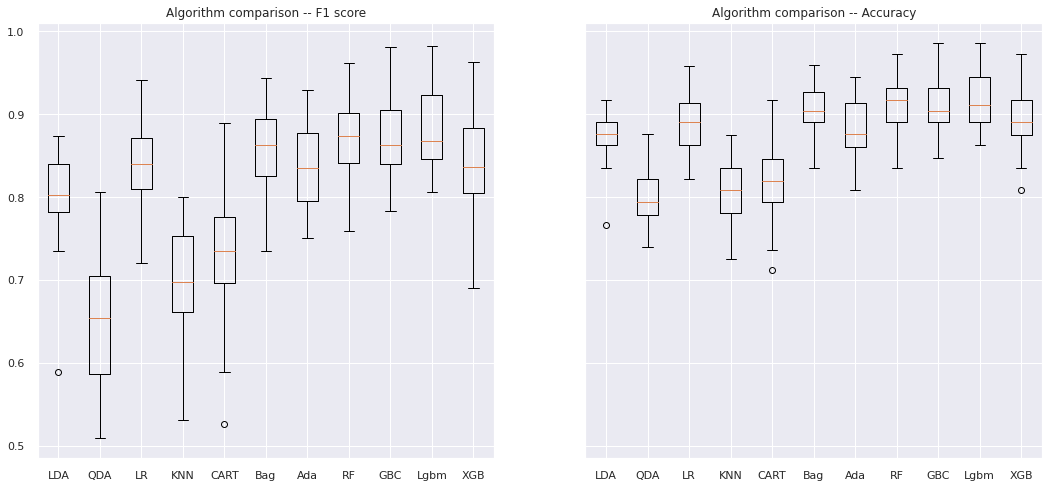

CPU times: user 5.7 s, sys: 244 ms, total: 5.95 s
Wall time: 4min 19s


In [38]:
%%time
# Model selection 
# Create a list of standard classifiers
tuned_models = []


tuned_models.append(('LDA', LinearDiscriminantAnalysis(solver='eigen', 
                                                        shrinkage=0.01)))

tuned_models.append(('QDA', QuadraticDiscriminantAnalysis(reg_param=0.1)))


tuned_models.append(('LR', LogisticRegression(penalty= 'l2', 
                                                        C=1000, 
                                                        random_state=seed,
                                                        solver='newton-cg',
                                                        n_jobs=-1)))  

              
tuned_models.append(('KNN', KNeighborsClassifier( weights= 'distance', 
                                                 n_neighbors = 4, 
                                                 metric = 'manhattan', 
                                                 n_jobs=-1)))    
 
      
tuned_models.append(('CART', DecisionTreeClassifier(min_samples_split = 2, 
                                                    min_samples_leaf = 10, 
                                                    max_features = 'auto', 
                                                    max_depth =87,
                                                    criterion = 'gini', 
                                                    random_state=seed))) 



tuned_models.append(('Bag', BaggingClassifier(n_estimators=32, 
                                                  max_samples=0.5, 
                                                  max_features=0.8, 
                                                  bootstrap=False,
                                                  n_jobs=-1,
                                                  random_state=seed))) 
                                                        


tuned_models.append(('Ada', AdaBoostClassifier(DecisionTreeClassifier(splitter = 'best', criterion ='entropy',),
                                                    n_estimators=700, 
                                                    learning_rate=0.25, 
                                                    algorithm ='SAMME',
                                                    random_state=seed)))


tuned_models.append(('RF', RandomForestClassifier(n_estimators=200, 
                                                  min_samples_split=15, 
                                                  min_samples_leaf=5, 
                                                  max_features='auto', 
                                                  max_depth=75, 
                                                  criterion='entropy', 
                                                  bootstrap=False,
                                                  n_jobs=-1,
                                                  random_state=seed)))


tuned_models.append(('GBC', GradientBoostingClassifier(subsample=0.9, 
                                                                n_estimators=400, 
                                                                min_samples_split=20, 
                                                                min_samples_leaf=20,  
                                                                max_depth= 64, 
                                                                learning_rate=0.05, 
                                                                criterion= 'mse',
                                                                random_state=seed,
                                                                max_features= 'log2')))


tuned_models.append(('Lgbm', LGBMClassifier(reg_lambda=5, 
                                                reg_alpha= 2, 
                                                n_estimators=700, 
                                                learning_rate=0.1,
                                                boosting_type='dart',
                                                n_jobs=-1,
                                                random_state=seed)))


tuned_models.append(('XGB', XGBClassifier(subsample=0.94, 
                                              reg_lambda=50, 
                                              reg_alpha=2, 
                                              n_estimators=600, 
                                              min_child_weight=0.0871, 
                                              max_depth=104, 
                                              learning_rate=1, 
                                              gamma=2, 
                                              colsample_bytree=0.239,
                                              n_jobs=-1, 
                                              random_state=seed)))


#evaluate the models using the new data and the tuned models
spot_checking3 = ModelComparison(train_data=new_train_data, test_size=0.3,
                                 n_cols=11, n_splits=10)

# get the data
train_X, train_Y, test_X, test_Y = spot_checking3.train_valid_test_data()
spot_checking3.evaluate_models(tuned_models)
spot_checking3.box_plots ()

## **Part 5: Model Training:**

**Fitting the tuned models to the train (new) data and testing them**

In [39]:
## Without Data Augumentation
spot_checking3.model_train_validation (tuned_models, oversample=False)

LDA

Train results:

>precision_macro: 0.8681852566777963
>recall_macro: 0.7888755858455619
>f1_macro: 0.8266324752943063
Confusion Matrix:

Test results:

>precision_macro: 0.7951398316589737
>recall_macro: 0.7424174843889384
>f1_macro: 0.7678747418340846
Confusion Matrix:
[[220  16]
 [ 34  42]]
-----------------------------------------------------------------
QDA

Train results:

>precision_macro: 0.7935739436619718
>recall_macro: 0.6399224330242934
>f1_macro: 0.7085135017735662
Confusion Matrix:

Test results:

>precision_macro: 0.7229365170474114
>recall_macro: 0.6082738626226584
>f1_macro: 0.6606670055628432
Confusion Matrix:
[[225  11]
 [ 56  20]]
-----------------------------------------------------------------
LR

Train results:

>precision_macro: 0.8665395725014442
>recall_macro: 0.824635189619533
>f1_macro: 0.845068222028541
Confusion Matrix:

Test results:

>precision_macro: 0.820138888888889
>recall_macro: 0.8084299732381801
>f1_macro: 0.8142423392893077
Confusion Matrix:
[

In [40]:
## With data augumentation
spot_checking4 = ModelComparison(train_data=new_train_data, test_size=0.3, n_cols=11, n_splits=10, k=3)
spot_checking4.model_train_validation (tuned_models, oversample=True)

LDA

Train results:

>precision_macro: 0.841752294948623
>recall_macro: 0.8415300546448088
>f1_macro: 0.841641160125751
Confusion Matrix:

Test results:

>precision_macro: 0.7633053221288515
>recall_macro: 0.8144513826940232
>f1_macro: 0.7880493527617005
Confusion Matrix:
[[195  41]
 [ 15  61]]
-----------------------------------------------------------------
QDA

Train results:

>precision_macro: 0.8068087433561772
>recall_macro: 0.7978142076502732
>f1_macro: 0.8022862665678445
Confusion Matrix:

Test results:

>precision_macro: 0.6854771088378333
>recall_macro: 0.7466547725245317
>f1_macro: 0.7147592500813607
Confusion Matrix:
[[163  73]
 [ 15  61]]
-----------------------------------------------------------------
LR

Train results:

>precision_macro: 0.8561020036429873
>recall_macro: 0.8561020036429873
>f1_macro: 0.8561020036429873
Confusion Matrix:

Test results:

>precision_macro: 0.7633053221288515
>recall_macro: 0.8144513826940232
>f1_macro: 0.7880493527617005
Confusion Matrix:


We can see that SMOTE made the performance of the models even worse. Therefore, we won't be using it.

Based on these results we can see signs of overfitting.

## **Part 5: Model Testing:**